In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imp
import functions

from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import datetime as dt
def padInput(input):
    max_length = np.max([len(i) for i in input])
    input_size = len(input)
    input_pad = np.zeros((input_size, max_length))
    
    for idx_row, row in enumerate(input):
        for idx_col, col in enumerate(row):
            input_pad[idx_row][idx_col]=col
            
    return input_pad

karate_club = [[2, 1],
[3, 1], [3, 2],
[4, 1], [4, 2], [4, 3],
[5, 1],
[6, 1],
[7, 1], [7, 5], [7, 6],
[8, 1], [8, 2], [8, 3], [8, 4],
[9, 1], [9, 3],
[10, 3],
[11, 1], [11, 5], [11, 6],
[12, 1],
[13, 1], [13, 4],
[14, 1], [14, 2], [14, 3], [14, 4],
[17, 6], [17, 7],
[18, 1], [18, 2],
[20, 1], [20, 2],
[22, 1], [22, 2],
[26, 24], [26, 25],
[28, 3], [28, 24], [28, 25],
[29, 3],
[30, 24], [30, 27],
[31, 2], [31, 9],
[32, 1], [32, 25], [32, 26], [32, 29],
[33, 3], [33, 9], [33, 15], [33, 16], [33, 19], [33, 21], [33, 23], [33, 24], [33, 30], [33, 31], [33, 32],
[34, 9], [34, 10], [34, 14], [34, 15], [34, 16], [34, 19], [34, 20], [34, 21], [34, 23], [34, 24], [34, 27],
               [34, 28], [34, 29], [34, 30], [34, 31], [34, 32], [34, 33],]

In [2]:
dummy_graph = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], 
              [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]]

In [3]:
karate_club = [[karate_club[idx][0]-1,karate_club[idx][1]-1] for idx in range(len(karate_club))]

In [4]:
#graph = pickle.load(open('backup/graph_root_sina.pkl', 'rb'))
#domains = pickle.load(open('backup/domains_root_sina.pkl', 'rb'))
graph_file = pickle.load(open('graph.pkl', 'rb'))
domains_file = pickle.load(open('domains.pkl', 'rb'))
#graph = karate_club
#graph = dummy_graph

In [8]:
unique_keys = set([])
for key in graph_file.keys():
    keys = [i for i in graph_file[key] if isinstance(i, dt.datetime)==False]
    
    unique_keys = unique_keys.union(keys)

unique_keys = unique_keys | set(graph_file.keys())

In [9]:
vocab_dict = {key:idx for idx, key in enumerate(unique_keys)}
inv_map = {values:keys for keys, values in vocab_dict.items()}

In [10]:
#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 2):
        key = graph_file[node][idx]
        #print (key)
        web_graph.add_edge(vocab_dict[node], vocab_dict[key])

In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

In [12]:
#for connection in graph:
#    web_graph.add_edge(connection[0], connection[1])

In [13]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=100)#, with_labels=True)
plt.savefig('nytimes_root_graph_undirected.png')
#plt.show()

In [14]:
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph[initial_node]]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

In [16]:
def generateBatchKuhan(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch): #double / gives you a integer

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

In [17]:
max_step = 10 #Window size and max_step must be connected

num_skips = 4 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  # Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 16# Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [18]:
print (len(list_of_nodes), num_steps)

1988 31


In [19]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Ops and variables pinned to the CPU because of missing GPU implementation
    #with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [20]:
#For sanity checking
#batch_inputs = [2, 2, 0, 0, 13, 15, 7, 8, 9, 10, 11, 14, 6, 6, 1, 1]
#batch_labels = [[3], [3], [13], [0], [15], [11], [15], [13], [14], [2], [7], [8], [3], [3], [3], [3]]

In [ ]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Conduct shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            random_walks.append(path)
        
        data_windows = np.array(random_walks)

        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):
        #for step in range(16):

            batch_data = generateBatchKuhan(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
            
            #batch_inputs = [row for row in range(batch_size)]
            #batch_labels = [[row] for row in range(batch_size)]
            #print (batch_inputs, batch_labels)
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
            
            #if step%15==0:
            #    print (step, loss_val, num_steps)

        #if epoch!=0: average_loss /= num_steps #This is the averaged over the steps, this means data is passed through only once?
        #I think because num_steps> length of data, we must recycle through the data set
        #but each time data is randomly generated, because we are using different context words

        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('Average loss  %.7g' % (float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss  57.45865
Average loss  51.07212
Average loss  49.61801
Average loss  46.79736
Average loss  46.19139
Average loss  45.6637
Average loss  44.98762
Average loss  43.94054
Average loss  46.68632
Average loss  44.85477
Average loss  44.18411
Average loss  40.62144
Average loss  42.09242
Average loss  38.26098
Average loss  39.48949
Average loss  39.12683
Average loss  37.14503
Average loss  39.33676
Average loss  37.08147
Average loss  39.41416
Average loss  38.17757
Average loss  36.34815
Average loss  35.31122
Average loss  34.34277
Average loss  35.66762
Average loss  34.46153
Average loss  34.66431
Average loss  31.98943
Average loss  32.57069
Average loss  34.63416
Average loss  35.55238
Average loss  32.99708
Average loss  33.28864
Average loss  31.80834
Average loss  29.31136
Average loss  31.29428
Average loss  27.19992
Average loss  30.79218
Average loss  32.0225
Average loss  28.77036
Average loss  30.26955
Average loss  29.02109
Average loss  29.19537
A

Average loss  3.355783
Average loss  2.625892
Average loss  3.159367
Average loss  3.465736
Average loss  2.864307
Average loss  2.709296
Average loss  3.16811
Average loss  3.029448
Average loss  3.2157
Average loss  3.328879
Average loss  3.043204
Average loss  2.790766
Average loss  2.738522
Average loss  2.906892
Average loss  2.941817
Average loss  2.844268
Average loss  3.00257
Average loss  2.889939
Average loss  3.268634
Average loss  2.903712
Average loss  2.784692
Average loss  2.611935
Average loss  2.853829
Average loss  2.506317
Average loss  3.268975
Average loss  2.690544
Average loss  3.23829
Average loss  2.191471
Average loss  2.543808
Average loss  2.477703
Average loss  2.613533
Average loss  2.755661
Average loss  2.650217
Average loss  2.825154
Average loss  2.616149
Average loss  3.19402
Average loss  2.609045
Average loss  2.454068
Average loss  2.766679
Average loss  2.918829
Average loss  2.538808
Average loss  2.702187
Average loss  2.454733
Average loss  2.7

Average loss  1.304584
Average loss  1.167314
Average loss  1.203447
Average loss  1.548071
Average loss  1.344175
Average loss  1.505307
Average loss  1.286161
Average loss  1.425981
Average loss  1.19118
Average loss  1.529592
Average loss  1.532216
Average loss  1.32515
Average loss  1.250365
Average loss  1.27065
Average loss  1.502878
Average loss  1.401866
Average loss  1.159956
Average loss  1.31026
Average loss  1.320066
Average loss  1.238753
Average loss  1.195908
Average loss  1.338578
Average loss  1.28277
Average loss  1.417714
Average loss  1.135909
Average loss  1.444135
Average loss  1.263617
Average loss  1.162009
Average loss  1.174275
Average loss  1.225175
Average loss  1.299967
Average loss  1.317793
Average loss  1.189201
Average loss  1.244233
Average loss  1.537235
Average loss  1.187885
Average loss  1.162858
Average loss  1.344402
Average loss  1.265082
Average loss  1.49847
Average loss  1.520005
Average loss  1.246664
Average loss  1.173988
Average loss  1.4

<IPython.core.display.Javascript object>


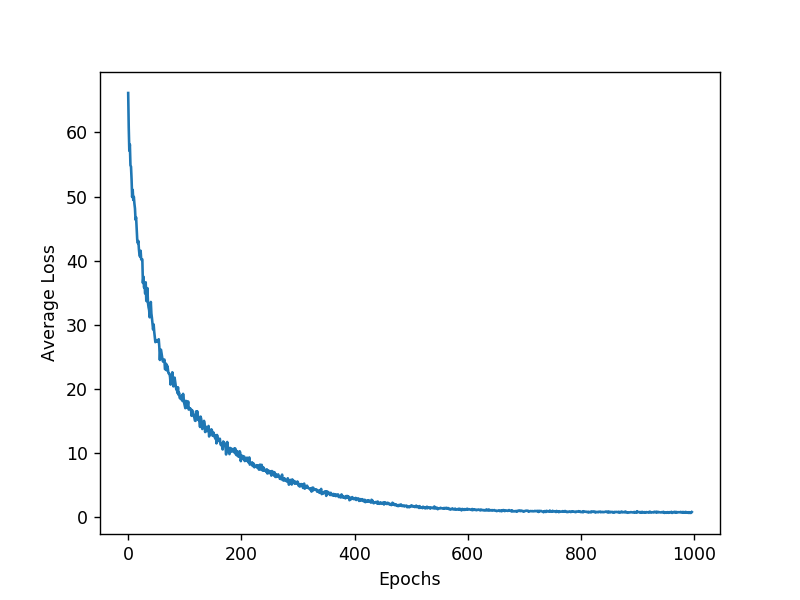

In [129]:
list_loss = np.array(avg_loss_record)
plt.figure()
plt.plot([i for i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [130]:
#tf.reset_default_graph()

In [131]:
vector = tf.placeholder(dtype=tf.float32)
#Create similarity matrix
mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [132]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [133]:
sim_matrix = matrices[0]

In [134]:
sim_matrix = np.array([[value if value==value else 0 for value in row] for row in sim_matrix])

In [135]:
np.fill_diagonal(sim_matrix, 0)

In [136]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [138]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [139]:
results = np.array(results)

In [140]:
np.argsort(results[:,0])

array([2672, 2750, 7430, ..., 2002, 7690,  604], dtype=int64)

In [141]:
results[2672]

array([  4.25068617e-01,   2.75000000e+03])

In [142]:
sim = sim_matrix[2672]

In [143]:
top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

In [144]:
top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.42506861686706543,
  0.65167796611785889,
  0.68049198389053345,
  0.68956124782562256],
 [2672, 2750, 7561, 5216, 3467],
 [1.4181159734725952,
  1.4218312501907349,
  1.4221513271331787,
  1.453068733215332,
  1.4960950613021851],
 [2044, 3640, 4868, 8534, 5284])

In [145]:
[inv_map[i] for i in top_n_nodes]

['https://developer.twitter.com/en/docs/ads/general/guides/getting-started',
 datetime.datetime(2018, 2, 15, 15, 3, 16, 59124),
 datetime.datetime(2018, 2, 15, 15, 7, 37, 723590),
 datetime.datetime(2018, 2, 15, 14, 46, 42, 861699),
 datetime.datetime(2018, 2, 15, 15, 9, 15, 157010)]

In [84]:
web_graph[763], web_graph[6812], web_graph[1807]

(AtlasView({1154: {}, 900: {}, 231: {}, 5610: {}, 4818: {}, 1840: {}, 1746: {}, 1407: {}, 4856: {}, 731: {}, 5450: {}, 6111: {}}),
 AtlasView({1154: {}, 900: {}, 231: {}, 5610: {}, 4818: {}, 1840: {}, 1746: {}, 1407: {}, 4856: {}, 731: {}, 5450: {}, 6111: {}}),
 AtlasView({1840: {}, 5610: {}, 1154: {}, 731: {}, 900: {}, 231: {}, 4856: {}, 5450: {}, 6111: {}, 1746: {}, 1407: {}}))

In [262]:
top_n_node_connections = [set([q for q in web_graph[i]]) for i in top_n_nodes]
bottom_n_node_connections = [set([q for q in web_graph[i]]) for i in bottom_n_nodes]

In [276]:
#top_n_node_connections, bottom_n_node_connections

In [264]:
[top_n_node_connections[0] & nodes for nodes in top_n_node_connections]

[{8284}, set(), set(), set(), set()]

In [265]:
[top_n_node_connections[0] & nodes for nodes in bottom_n_node_connections]

[set(), set(), set(), set(), set()]

In [ ]:
learning_grid = [50]
perplexity_grid = [15, 50, 100]

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=40000, 
                    verbose=9, metric='precomputed')
        
        low_dim_embs = tsne.fit_transform(sim_matrix)
        pickle.dump(low_dim_embs, open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'wb'))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 8787 samples in 0.110s...
[t-SNE] Computed neighbors for 8787 samples in 1.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8787
[t-SNE] Computed conditional probabilities for sample 2000 / 8787
[t-SNE] Computed conditional probabilities for sample 3000 / 8787
[t-SNE] Computed conditional probabilities for sample 4000 / 8787
[t-SNE] Computed conditional probabilities for sample 5000 / 8787
[t-SNE] Computed conditional probabilities for sample 6000 / 8787
[t-SNE] Computed conditional probabilities for sample 7000 / 8787
[t-SNE] Computed conditional probabilities for sample 8000 / 8787
[t-SNE] Computed conditional probabilities for sample 8787 / 8787
[t-SNE] Mean sigma: 0.137131
[t-SNE] Computed conditional probabilities in 0.087s
[t-SNE] Iteration 50: error = 117.1727524, gradient norm = 0.0000060 (50 iterations in 9.654s)
[t-SNE] Iteration 100: error = 117.1727524, gradient norm = 0.0000009 (50 iterations in 

[t-SNE] Iteration 3900: error = 3.8956449, gradient norm = 0.0002550 (50 iterations in 7.461s)
[t-SNE] Iteration 3950: error = 3.8845007, gradient norm = 0.0002507 (50 iterations in 7.347s)
[t-SNE] Iteration 4000: error = 3.8736463, gradient norm = 0.0002469 (50 iterations in 7.328s)
[t-SNE] Iteration 4050: error = 3.8629663, gradient norm = 0.0002433 (50 iterations in 7.344s)
[t-SNE] Iteration 4100: error = 3.8525050, gradient norm = 0.0002389 (50 iterations in 7.316s)
[t-SNE] Iteration 4150: error = 3.8423023, gradient norm = 0.0002352 (50 iterations in 7.431s)
[t-SNE] Iteration 4200: error = 3.8322508, gradient norm = 0.0002317 (50 iterations in 7.356s)
[t-SNE] Iteration 4250: error = 3.8224325, gradient norm = 0.0002275 (50 iterations in 7.365s)
[t-SNE] Iteration 4300: error = 3.8128300, gradient norm = 0.0002235 (50 iterations in 7.424s)
[t-SNE] Iteration 4350: error = 3.8034039, gradient norm = 0.0002196 (50 iterations in 7.349s)
[t-SNE] Iteration 4400: error = 3.7941463, gradien

[t-SNE] Iteration 8250: error = 3.3991363, gradient norm = 0.0000994 (50 iterations in 7.619s)
[t-SNE] Iteration 8300: error = 3.3964980, gradient norm = 0.0000986 (50 iterations in 7.519s)
[t-SNE] Iteration 8350: error = 3.3938680, gradient norm = 0.0000981 (50 iterations in 7.519s)
[t-SNE] Iteration 8400: error = 3.3912876, gradient norm = 0.0000978 (50 iterations in 7.641s)
[t-SNE] Iteration 8450: error = 3.3887374, gradient norm = 0.0000968 (50 iterations in 7.638s)
[t-SNE] Iteration 8500: error = 3.3862224, gradient norm = 0.0000964 (50 iterations in 7.591s)
[t-SNE] Iteration 8550: error = 3.3837657, gradient norm = 0.0000954 (50 iterations in 7.543s)
[t-SNE] Iteration 8600: error = 3.3812790, gradient norm = 0.0000946 (50 iterations in 7.547s)
[t-SNE] Iteration 8650: error = 3.3788855, gradient norm = 0.0000943 (50 iterations in 7.666s)
[t-SNE] Iteration 8700: error = 3.3764710, gradient norm = 0.0000934 (50 iterations in 7.537s)
[t-SNE] Iteration 8750: error = 3.3741331, gradien

[t-SNE] Iteration 12550: error = 3.2719760, gradient norm = 0.0000799 (50 iterations in 7.940s)
[t-SNE] Iteration 12600: error = 3.2713523, gradient norm = 0.0000797 (50 iterations in 7.618s)
[t-SNE] Iteration 12650: error = 3.2707038, gradient norm = 0.0000797 (50 iterations in 7.690s)
[t-SNE] Iteration 12700: error = 3.2701087, gradient norm = 0.0000794 (50 iterations in 7.728s)
[t-SNE] Iteration 12750: error = 3.2695007, gradient norm = 0.0000783 (50 iterations in 7.712s)
[t-SNE] Iteration 12800: error = 3.2688911, gradient norm = 0.0000792 (50 iterations in 7.605s)
[t-SNE] Iteration 12850: error = 3.2683072, gradient norm = 0.0000788 (50 iterations in 7.648s)
[t-SNE] Iteration 12900: error = 3.2676973, gradient norm = 0.0000790 (50 iterations in 7.751s)
[t-SNE] Iteration 12950: error = 3.2671158, gradient norm = 0.0000787 (50 iterations in 7.812s)
[t-SNE] Iteration 13000: error = 3.2665269, gradient norm = 0.0000781 (50 iterations in 7.779s)
[t-SNE] Iteration 13050: error = 3.26600

[t-SNE] Iteration 16850: error = 3.2364736, gradient norm = 0.0000673 (50 iterations in 8.088s)
[t-SNE] Iteration 16900: error = 3.2361643, gradient norm = 0.0000671 (50 iterations in 7.926s)
[t-SNE] Iteration 16950: error = 3.2358658, gradient norm = 0.0000664 (50 iterations in 8.117s)
[t-SNE] Iteration 17000: error = 3.2355721, gradient norm = 0.0000661 (50 iterations in 8.014s)
[t-SNE] Iteration 17050: error = 3.2352669, gradient norm = 0.0000658 (50 iterations in 8.049s)
[t-SNE] Iteration 17100: error = 3.2349787, gradient norm = 0.0000660 (50 iterations in 7.979s)
[t-SNE] Iteration 17150: error = 3.2346799, gradient norm = 0.0000661 (50 iterations in 8.094s)
[t-SNE] Iteration 17200: error = 3.2343633, gradient norm = 0.0000667 (50 iterations in 8.051s)
[t-SNE] Iteration 17250: error = 3.2340488, gradient norm = 0.0000664 (50 iterations in 8.018s)
[t-SNE] Iteration 17300: error = 3.2337174, gradient norm = 0.0000664 (50 iterations in 7.987s)
[t-SNE] Iteration 17350: error = 3.23339

[t-SNE] Iteration 21150: error = 3.2125504, gradient norm = 0.0000586 (50 iterations in 8.168s)
[t-SNE] Iteration 21200: error = 3.2123430, gradient norm = 0.0000590 (50 iterations in 8.182s)
[t-SNE] Iteration 21250: error = 3.2120864, gradient norm = 0.0000584 (50 iterations in 8.281s)
[t-SNE] Iteration 21300: error = 3.2118492, gradient norm = 0.0000575 (50 iterations in 8.229s)
[t-SNE] Iteration 21350: error = 3.2115984, gradient norm = 0.0000575 (50 iterations in 8.252s)
[t-SNE] Iteration 21400: error = 3.2113781, gradient norm = 0.0000579 (50 iterations in 8.227s)
[t-SNE] Iteration 21450: error = 3.2111320, gradient norm = 0.0000576 (50 iterations in 8.179s)
[t-SNE] Iteration 21500: error = 3.2108972, gradient norm = 0.0000577 (50 iterations in 8.240s)
[t-SNE] Iteration 21550: error = 3.2106380, gradient norm = 0.0000581 (50 iterations in 8.324s)
[t-SNE] Iteration 21600: error = 3.2104080, gradient norm = 0.0000581 (50 iterations in 8.266s)
[t-SNE] Iteration 21650: error = 3.21015

[t-SNE] Iteration 25450: error = 3.1919930, gradient norm = 0.0000533 (50 iterations in 8.372s)
[t-SNE] Iteration 25500: error = 3.1917691, gradient norm = 0.0000536 (50 iterations in 8.360s)
[t-SNE] Iteration 25550: error = 3.1915596, gradient norm = 0.0000533 (50 iterations in 8.342s)
[t-SNE] Iteration 25600: error = 3.1913421, gradient norm = 0.0000529 (50 iterations in 8.359s)
[t-SNE] Iteration 25650: error = 3.1911309, gradient norm = 0.0000522 (50 iterations in 8.286s)
[t-SNE] Iteration 25700: error = 3.1909482, gradient norm = 0.0000530 (50 iterations in 8.421s)
[t-SNE] Iteration 25750: error = 3.1907313, gradient norm = 0.0000527 (50 iterations in 8.377s)
[t-SNE] Iteration 25800: error = 3.1905200, gradient norm = 0.0000527 (50 iterations in 8.396s)
[t-SNE] Iteration 25850: error = 3.1903353, gradient norm = 0.0000523 (50 iterations in 8.394s)
[t-SNE] Iteration 25900: error = 3.1901305, gradient norm = 0.0000521 (50 iterations in 8.291s)
[t-SNE] Iteration 25950: error = 3.18990

[t-SNE] Iteration 29750: error = 3.1757207, gradient norm = 0.0000491 (50 iterations in 8.387s)
[t-SNE] Iteration 29800: error = 3.1755106, gradient norm = 0.0000489 (50 iterations in 8.421s)
[t-SNE] Iteration 29850: error = 3.1753485, gradient norm = 0.0000487 (50 iterations in 8.380s)
[t-SNE] Iteration 29900: error = 3.1751819, gradient norm = 0.0000488 (50 iterations in 8.422s)
[t-SNE] Iteration 29950: error = 3.1749761, gradient norm = 0.0000490 (50 iterations in 8.586s)
[t-SNE] Iteration 30000: error = 3.1747856, gradient norm = 0.0000491 (50 iterations in 8.544s)
[t-SNE] Iteration 30050: error = 3.1746273, gradient norm = 0.0000486 (50 iterations in 8.447s)
[t-SNE] Iteration 30100: error = 3.1744690, gradient norm = 0.0000485 (50 iterations in 8.452s)
[t-SNE] Iteration 30150: error = 3.1743228, gradient norm = 0.0000489 (50 iterations in 8.772s)
[t-SNE] Iteration 30200: error = 3.1741347, gradient norm = 0.0000488 (50 iterations in 8.990s)
[t-SNE] Iteration 30250: error = 3.17398

[t-SNE] Iteration 34050: error = 3.1645982, gradient norm = 0.0000446 (50 iterations in 8.491s)
[t-SNE] Iteration 34100: error = 3.1644893, gradient norm = 0.0000446 (50 iterations in 8.597s)
[t-SNE] Iteration 34150: error = 3.1643972, gradient norm = 0.0000441 (50 iterations in 8.673s)
[t-SNE] Iteration 34200: error = 3.1642954, gradient norm = 0.0000446 (50 iterations in 8.654s)
[t-SNE] Iteration 34250: error = 3.1642118, gradient norm = 0.0000441 (50 iterations in 8.912s)
[t-SNE] Iteration 34300: error = 3.1640916, gradient norm = 0.0000443 (50 iterations in 8.620s)
[t-SNE] Iteration 34350: error = 3.1639452, gradient norm = 0.0000440 (50 iterations in 8.525s)
[t-SNE] Iteration 34400: error = 3.1638598, gradient norm = 0.0000439 (50 iterations in 8.569s)
[t-SNE] Iteration 34450: error = 3.1637678, gradient norm = 0.0000438 (50 iterations in 8.594s)
[t-SNE] Iteration 34500: error = 3.1636679, gradient norm = 0.0000445 (50 iterations in 8.481s)
[t-SNE] Iteration 34550: error = 3.16354

[t-SNE] Iteration 38350: error = 3.1548972, gradient norm = 0.0000425 (50 iterations in 8.710s)
[t-SNE] Iteration 38400: error = 3.1547947, gradient norm = 0.0000427 (50 iterations in 8.717s)
[t-SNE] Iteration 38450: error = 3.1547070, gradient norm = 0.0000423 (50 iterations in 8.648s)
[t-SNE] Iteration 38500: error = 3.1545908, gradient norm = 0.0000421 (50 iterations in 8.821s)
[t-SNE] Iteration 38550: error = 3.1544659, gradient norm = 0.0000420 (50 iterations in 8.682s)
[t-SNE] Iteration 38600: error = 3.1543541, gradient norm = 0.0000426 (50 iterations in 8.808s)
[t-SNE] Iteration 38650: error = 3.1542635, gradient norm = 0.0000428 (50 iterations in 8.684s)
[t-SNE] Iteration 38700: error = 3.1541507, gradient norm = 0.0000428 (50 iterations in 8.719s)
[t-SNE] Iteration 38750: error = 3.1540346, gradient norm = 0.0000421 (50 iterations in 8.739s)
[t-SNE] Iteration 38800: error = 3.1539190, gradient norm = 0.0000417 (50 iterations in 8.606s)
[t-SNE] Iteration 38850: error = 3.15381

[t-SNE] Iteration 700: error = 4.7676992, gradient norm = 0.0007393 (50 iterations in 7.636s)
[t-SNE] Iteration 750: error = 4.6586680, gradient norm = 0.0006612 (50 iterations in 7.685s)
[t-SNE] Iteration 800: error = 4.5618210, gradient norm = 0.0005965 (50 iterations in 7.595s)
[t-SNE] Iteration 850: error = 4.4750600, gradient norm = 0.0005414 (50 iterations in 7.605s)
[t-SNE] Iteration 900: error = 4.3963633, gradient norm = 0.0004958 (50 iterations in 7.443s)
[t-SNE] Iteration 950: error = 4.3246274, gradient norm = 0.0004540 (50 iterations in 7.619s)
[t-SNE] Iteration 1000: error = 4.2592893, gradient norm = 0.0004191 (50 iterations in 7.492s)
[t-SNE] Iteration 1050: error = 4.1989503, gradient norm = 0.0003894 (50 iterations in 7.439s)
[t-SNE] Iteration 1100: error = 4.1435676, gradient norm = 0.0003612 (50 iterations in 7.433s)
[t-SNE] Iteration 1150: error = 4.0924244, gradient norm = 0.0003390 (50 iterations in 7.438s)
[t-SNE] Iteration 1200: error = 4.0451922, gradient norm

[t-SNE] Iteration 5050: error = 3.2295449, gradient norm = 0.0000649 (50 iterations in 7.692s)
[t-SNE] Iteration 5100: error = 3.2283597, gradient norm = 0.0000643 (50 iterations in 7.704s)
[t-SNE] Iteration 5150: error = 3.2272794, gradient norm = 0.0000655 (50 iterations in 7.679s)
[t-SNE] Iteration 5200: error = 3.2261560, gradient norm = 0.0000673 (50 iterations in 7.697s)
[t-SNE] Iteration 5250: error = 3.2251723, gradient norm = 0.0000650 (50 iterations in 7.665s)
[t-SNE] Iteration 5300: error = 3.2241988, gradient norm = 0.0000632 (50 iterations in 7.728s)
[t-SNE] Iteration 5350: error = 3.2232924, gradient norm = 0.0000632 (50 iterations in 7.762s)
[t-SNE] Iteration 5400: error = 3.2223780, gradient norm = 0.0000632 (50 iterations in 7.745s)
[t-SNE] Iteration 5450: error = 3.2215214, gradient norm = 0.0000616 (50 iterations in 7.732s)
[t-SNE] Iteration 5500: error = 3.2206547, gradient norm = 0.0000617 (50 iterations in 7.860s)
[t-SNE] Iteration 5550: error = 3.2198534, gradien

[t-SNE] Iteration 9400: error = 3.1783404, gradient norm = 0.0000490 (50 iterations in 7.933s)
[t-SNE] Iteration 9450: error = 3.1778805, gradient norm = 0.0000492 (50 iterations in 7.928s)
[t-SNE] Iteration 9500: error = 3.1774726, gradient norm = 0.0000488 (50 iterations in 7.992s)
[t-SNE] Iteration 9550: error = 3.1770620, gradient norm = 0.0000486 (50 iterations in 7.899s)
[t-SNE] Iteration 9600: error = 3.1766524, gradient norm = 0.0000485 (50 iterations in 7.900s)
[t-SNE] Iteration 9650: error = 3.1762853, gradient norm = 0.0000480 (50 iterations in 7.938s)
[t-SNE] Iteration 9700: error = 3.1758740, gradient norm = 0.0000489 (50 iterations in 8.037s)
[t-SNE] Iteration 9750: error = 3.1754653, gradient norm = 0.0000484 (50 iterations in 7.899s)
[t-SNE] Iteration 9800: error = 3.1750934, gradient norm = 0.0000490 (50 iterations in 7.991s)
[t-SNE] Iteration 9850: error = 3.1746728, gradient norm = 0.0000484 (50 iterations in 7.995s)
[t-SNE] Iteration 9900: error = 3.1743021, gradien

[t-SNE] Iteration 13700: error = 3.1518435, gradient norm = 0.0000421 (50 iterations in 8.057s)
[t-SNE] Iteration 13750: error = 3.1515968, gradient norm = 0.0000420 (50 iterations in 8.098s)
[t-SNE] Iteration 13800: error = 3.1514001, gradient norm = 0.0000412 (50 iterations in 8.041s)
[t-SNE] Iteration 13850: error = 3.1511583, gradient norm = 0.0000404 (50 iterations in 8.164s)
[t-SNE] Iteration 13900: error = 3.1509366, gradient norm = 0.0000407 (50 iterations in 8.046s)
[t-SNE] Iteration 13950: error = 3.1507244, gradient norm = 0.0000412 (50 iterations in 8.196s)
[t-SNE] Iteration 14000: error = 3.1504986, gradient norm = 0.0000417 (50 iterations in 8.191s)
[t-SNE] Iteration 14050: error = 3.1502793, gradient norm = 0.0000407 (50 iterations in 8.140s)
[t-SNE] Iteration 14100: error = 3.1500759, gradient norm = 0.0000404 (50 iterations in 8.125s)
[t-SNE] Iteration 14150: error = 3.1498303, gradient norm = 0.0000402 (50 iterations in 8.126s)
[t-SNE] Iteration 14200: error = 3.14960

[t-SNE] Iteration 18000: error = 3.1299534, gradient norm = 0.0000368 (50 iterations in 8.279s)
[t-SNE] Iteration 18050: error = 3.1297758, gradient norm = 0.0000366 (50 iterations in 8.229s)
[t-SNE] Iteration 18100: error = 3.1296198, gradient norm = 0.0000373 (50 iterations in 8.051s)
[t-SNE] Iteration 18150: error = 3.1294272, gradient norm = 0.0000371 (50 iterations in 8.232s)
[t-SNE] Iteration 18200: error = 3.1292624, gradient norm = 0.0000362 (50 iterations in 8.222s)
[t-SNE] Iteration 18250: error = 3.1291077, gradient norm = 0.0000371 (50 iterations in 8.060s)
[t-SNE] Iteration 18300: error = 3.1289580, gradient norm = 0.0000367 (50 iterations in 8.280s)
[t-SNE] Iteration 18350: error = 3.1287568, gradient norm = 0.0000366 (50 iterations in 8.272s)
[t-SNE] Iteration 18400: error = 3.1286371, gradient norm = 0.0000367 (50 iterations in 8.328s)
[t-SNE] Iteration 18450: error = 3.1284959, gradient norm = 0.0000372 (50 iterations in 8.133s)
[t-SNE] Iteration 18500: error = 3.12837

[t-SNE] Iteration 22300: error = 3.1189864, gradient norm = 0.0000343 (50 iterations in 8.241s)
[t-SNE] Iteration 22350: error = 3.1188736, gradient norm = 0.0000349 (50 iterations in 8.279s)
[t-SNE] Iteration 22400: error = 3.1187506, gradient norm = 0.0000348 (50 iterations in 8.313s)
[t-SNE] Iteration 22450: error = 3.1186342, gradient norm = 0.0000357 (50 iterations in 8.256s)
[t-SNE] Iteration 22500: error = 3.1185708, gradient norm = 0.0000346 (50 iterations in 8.214s)
[t-SNE] Iteration 22550: error = 3.1184893, gradient norm = 0.0000333 (50 iterations in 8.243s)
[t-SNE] Iteration 22600: error = 3.1183867, gradient norm = 0.0000345 (50 iterations in 8.162s)
[t-SNE] Iteration 22650: error = 3.1182644, gradient norm = 0.0000345 (50 iterations in 8.151s)
[t-SNE] Iteration 22700: error = 3.1182048, gradient norm = 0.0000344 (50 iterations in 8.367s)
[t-SNE] Iteration 22750: error = 3.1180859, gradient norm = 0.0000347 (50 iterations in 8.255s)
[t-SNE] Iteration 22800: error = 3.11799

[t-SNE] Iteration 26600: error = 3.1107230, gradient norm = 0.0000322 (50 iterations in 8.101s)
[t-SNE] Iteration 26650: error = 3.1106000, gradient norm = 0.0000321 (50 iterations in 8.122s)
[t-SNE] Iteration 26700: error = 3.1104994, gradient norm = 0.0000336 (50 iterations in 8.043s)
[t-SNE] Iteration 26750: error = 3.1104112, gradient norm = 0.0000321 (50 iterations in 8.092s)
[t-SNE] Iteration 26800: error = 3.1103663, gradient norm = 0.0000322 (50 iterations in 8.164s)
[t-SNE] Iteration 26850: error = 3.1102195, gradient norm = 0.0000335 (50 iterations in 8.054s)
[t-SNE] Iteration 26900: error = 3.1101658, gradient norm = 0.0000338 (50 iterations in 8.075s)
[t-SNE] Iteration 26950: error = 3.1100721, gradient norm = 0.0000326 (50 iterations in 8.078s)
[t-SNE] Iteration 27000: error = 3.1100094, gradient norm = 0.0000321 (50 iterations in 8.064s)
[t-SNE] Iteration 27050: error = 3.1098948, gradient norm = 0.0000331 (50 iterations in 8.114s)
[t-SNE] Iteration 27100: error = 3.10980

[t-SNE] Iteration 30900: error = 3.1037686, gradient norm = 0.0000322 (50 iterations in 7.954s)
[t-SNE] Iteration 30950: error = 3.1036758, gradient norm = 0.0000315 (50 iterations in 7.942s)
[t-SNE] Iteration 31000: error = 3.1035774, gradient norm = 0.0000329 (50 iterations in 7.906s)
[t-SNE] Iteration 31050: error = 3.1035850, gradient norm = 0.0000317 (50 iterations in 7.889s)
[t-SNE] Iteration 31100: error = 3.1035407, gradient norm = 0.0000313 (50 iterations in 7.937s)
[t-SNE] Iteration 31150: error = 3.1034575, gradient norm = 0.0000306 (50 iterations in 7.904s)
[t-SNE] Iteration 31200: error = 3.1033494, gradient norm = 0.0000321 (50 iterations in 7.999s)
[t-SNE] Iteration 31250: error = 3.1032472, gradient norm = 0.0000339 (50 iterations in 7.931s)
[t-SNE] Iteration 31300: error = 3.1031945, gradient norm = 0.0000331 (50 iterations in 7.963s)
[t-SNE] Iteration 31350: error = 3.1031303, gradient norm = 0.0000320 (50 iterations in 7.921s)
[t-SNE] Iteration 31400: error = 3.10304

[t-SNE] Iteration 35200: error = 3.0990310, gradient norm = 0.0000313 (50 iterations in 7.928s)
[t-SNE] Iteration 35250: error = 3.0989790, gradient norm = 0.0000320 (50 iterations in 7.930s)
[t-SNE] Iteration 35300: error = 3.0989437, gradient norm = 0.0000331 (50 iterations in 8.010s)
[t-SNE] Iteration 35350: error = 3.0988748, gradient norm = 0.0000333 (50 iterations in 7.962s)
[t-SNE] Iteration 35400: error = 3.0988808, gradient norm = 0.0000340 (50 iterations in 7.985s)
[t-SNE] Iteration 35450: error = 3.0987930, gradient norm = 0.0000321 (50 iterations in 7.886s)
[t-SNE] Iteration 35500: error = 3.0987742, gradient norm = 0.0000328 (50 iterations in 7.916s)
[t-SNE] Iteration 35550: error = 3.0987213, gradient norm = 0.0000323 (50 iterations in 7.963s)
[t-SNE] Iteration 35600: error = 3.0987222, gradient norm = 0.0000314 (50 iterations in 7.908s)
[t-SNE] Iteration 35650: error = 3.0986631, gradient norm = 0.0000313 (50 iterations in 7.865s)
[t-SNE] Iteration 35700: error = 3.09858

[t-SNE] Iteration 39500: error = 3.0951898, gradient norm = 0.0000288 (50 iterations in 7.947s)
[t-SNE] Iteration 39550: error = 3.0950847, gradient norm = 0.0000318 (50 iterations in 8.080s)
[t-SNE] Iteration 39600: error = 3.0950296, gradient norm = 0.0000338 (50 iterations in 8.042s)
[t-SNE] Iteration 39650: error = 3.0949836, gradient norm = 0.0000300 (50 iterations in 8.038s)
[t-SNE] Iteration 39700: error = 3.0949233, gradient norm = 0.0000311 (50 iterations in 7.899s)
[t-SNE] Iteration 39750: error = 3.0948565, gradient norm = 0.0000307 (50 iterations in 8.024s)
[t-SNE] Iteration 39800: error = 3.0947943, gradient norm = 0.0000319 (50 iterations in 8.104s)
[t-SNE] Iteration 39850: error = 3.0947208, gradient norm = 0.0000310 (50 iterations in 8.108s)
[t-SNE] Iteration 39900: error = 3.0947239, gradient norm = 0.0000298 (50 iterations in 8.025s)
[t-SNE] Iteration 39950: error = 3.0946138, gradient norm = 0.0000309 (50 iterations in 7.895s)
[t-SNE] Iteration 40000: error = 3.09455

[t-SNE] Iteration 2050: error = 3.2871432, gradient norm = 0.0000664 (50 iterations in 7.726s)
[t-SNE] Iteration 2100: error = 3.2813427, gradient norm = 0.0000662 (50 iterations in 7.792s)
[t-SNE] Iteration 2150: error = 3.2759945, gradient norm = 0.0000653 (50 iterations in 7.855s)
[t-SNE] Iteration 2200: error = 3.2710388, gradient norm = 0.0000635 (50 iterations in 7.859s)
[t-SNE] Iteration 2250: error = 3.2664566, gradient norm = 0.0000631 (50 iterations in 7.853s)
[t-SNE] Iteration 2300: error = 3.2621455, gradient norm = 0.0000634 (50 iterations in 7.830s)
[t-SNE] Iteration 2350: error = 3.2582037, gradient norm = 0.0000627 (50 iterations in 7.927s)
[t-SNE] Iteration 2400: error = 3.2545211, gradient norm = 0.0000617 (50 iterations in 7.946s)
[t-SNE] Iteration 2450: error = 3.2510898, gradient norm = 0.0000612 (50 iterations in 7.794s)
[t-SNE] Iteration 2500: error = 3.2478950, gradient norm = 0.0000612 (50 iterations in 7.800s)
[t-SNE] Iteration 2550: error = 3.2449868, gradien

[t-SNE] Iteration 6400: error = 3.1538031, gradient norm = 0.0000365 (50 iterations in 8.704s)
[t-SNE] Iteration 6450: error = 3.1531677, gradient norm = 0.0000359 (50 iterations in 8.681s)
[t-SNE] Iteration 6500: error = 3.1525395, gradient norm = 0.0000360 (50 iterations in 8.702s)
[t-SNE] Iteration 6550: error = 3.1519208, gradient norm = 0.0000363 (50 iterations in 8.712s)
[t-SNE] Iteration 6600: error = 3.1513064, gradient norm = 0.0000368 (50 iterations in 8.650s)
[t-SNE] Iteration 6650: error = 3.1506772, gradient norm = 0.0000356 (50 iterations in 8.644s)
[t-SNE] Iteration 6700: error = 3.1500762, gradient norm = 0.0000349 (50 iterations in 8.765s)
[t-SNE] Iteration 6750: error = 3.1494799, gradient norm = 0.0000343 (50 iterations in 8.770s)
[t-SNE] Iteration 6800: error = 3.1489077, gradient norm = 0.0000350 (50 iterations in 8.730s)
[t-SNE] Iteration 6850: error = 3.1483021, gradient norm = 0.0000352 (50 iterations in 8.795s)
[t-SNE] Iteration 6900: error = 3.1477263, gradien

[t-SNE] Iteration 10750: error = 3.1168065, gradient norm = 0.0000268 (50 iterations in 9.243s)
[t-SNE] Iteration 10800: error = 3.1164963, gradient norm = 0.0000270 (50 iterations in 9.346s)
[t-SNE] Iteration 10850: error = 3.1162038, gradient norm = 0.0000291 (50 iterations in 9.349s)
[t-SNE] Iteration 10900: error = 3.1159244, gradient norm = 0.0000290 (50 iterations in 9.496s)
[t-SNE] Iteration 10950: error = 3.1156292, gradient norm = 0.0000281 (50 iterations in 9.404s)
[t-SNE] Iteration 11000: error = 3.1154048, gradient norm = 0.0000276 (50 iterations in 9.271s)
[t-SNE] Iteration 11050: error = 3.1151242, gradient norm = 0.0000269 (50 iterations in 9.373s)
[t-SNE] Iteration 11100: error = 3.1148803, gradient norm = 0.0000286 (50 iterations in 9.394s)
[t-SNE] Iteration 11150: error = 3.1146524, gradient norm = 0.0000267 (50 iterations in 9.527s)
[t-SNE] Iteration 11200: error = 3.1144142, gradient norm = 0.0000260 (50 iterations in 9.596s)
[t-SNE] Iteration 11250: error = 3.11416

[t-SNE] Iteration 15050: error = 3.0993273, gradient norm = 0.0000224 (50 iterations in 9.902s)
[t-SNE] Iteration 15100: error = 3.0991333, gradient norm = 0.0000227 (50 iterations in 9.960s)
[t-SNE] Iteration 15150: error = 3.0989621, gradient norm = 0.0000232 (50 iterations in 10.006s)
[t-SNE] Iteration 15200: error = 3.0987928, gradient norm = 0.0000225 (50 iterations in 10.090s)
[t-SNE] Iteration 15250: error = 3.0986328, gradient norm = 0.0000225 (50 iterations in 10.068s)
[t-SNE] Iteration 15300: error = 3.0984578, gradient norm = 0.0000224 (50 iterations in 9.961s)
[t-SNE] Iteration 15350: error = 3.0982804, gradient norm = 0.0000210 (50 iterations in 9.990s)
[t-SNE] Iteration 15400: error = 3.0981624, gradient norm = 0.0000215 (50 iterations in 9.935s)
[t-SNE] Iteration 15450: error = 3.0979846, gradient norm = 0.0000225 (50 iterations in 10.166s)
[t-SNE] Iteration 15500: error = 3.0978248, gradient norm = 0.0000207 (50 iterations in 10.086s)
[t-SNE] Iteration 15550: error = 3.

[t-SNE] Iteration 19300: error = 3.0872369, gradient norm = 0.0000177 (50 iterations in 10.690s)
[t-SNE] Iteration 19350: error = 3.0871110, gradient norm = 0.0000196 (50 iterations in 10.740s)
[t-SNE] Iteration 19400: error = 3.0870404, gradient norm = 0.0000180 (50 iterations in 10.716s)
[t-SNE] Iteration 19450: error = 3.0869446, gradient norm = 0.0000175 (50 iterations in 10.821s)
[t-SNE] Iteration 19500: error = 3.0868294, gradient norm = 0.0000201 (50 iterations in 10.690s)
[t-SNE] Iteration 19550: error = 3.0867271, gradient norm = 0.0000180 (50 iterations in 10.716s)
[t-SNE] Iteration 19600: error = 3.0866363, gradient norm = 0.0000182 (50 iterations in 10.725s)
[t-SNE] Iteration 19650: error = 3.0865567, gradient norm = 0.0000182 (50 iterations in 10.682s)
[t-SNE] Iteration 19700: error = 3.0864315, gradient norm = 0.0000194 (50 iterations in 10.745s)
[t-SNE] Iteration 19750: error = 3.0863240, gradient norm = 0.0000206 (50 iterations in 10.752s)
[t-SNE] Iteration 19800: error

In [285]:
tsne = TSNE(perplexity=10, n_components=2, learning_rate=1, n_iter=50000, verbose=9, metric='precomputed')
low_dim_embs = tsne.fit_transform(sim_matrix)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8787 samples in 0.097s...
[t-SNE] Computed neighbors for 8787 samples in 1.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8787
[t-SNE] Computed conditional probabilities for sample 2000 / 8787
[t-SNE] Computed conditional probabilities for sample 3000 / 8787
[t-SNE] Computed conditional probabilities for sample 4000 / 8787
[t-SNE] Computed conditional probabilities for sample 5000 / 8787
[t-SNE] Computed conditional probabilities for sample 6000 / 8787
[t-SNE] Computed conditional probabilities for sample 7000 / 8787
[t-SNE] Computed conditional probabilities for sample 8000 / 8787
[t-SNE] Computed conditional probabilities for sample 8787 / 8787
[t-SNE] Mean sigma: 0.160281
[t-SNE] Computed conditional probabilities in 0.141s
[t-SNE] Iteration 50: error = 109.2683563, gradient norm = 0.0000058 (50 iterations in 11.066s)
[t-SNE] Iteration 100: error = 109.2683563, gradient norm = 0.0000004 (50 iterations in

[t-SNE] Iteration 3900: error = 4.3404908, gradient norm = 0.0002171 (50 iterations in 9.252s)
[t-SNE] Iteration 3950: error = 4.3324389, gradient norm = 0.0002132 (50 iterations in 9.290s)
[t-SNE] Iteration 4000: error = 4.3245025, gradient norm = 0.0002091 (50 iterations in 9.226s)
[t-SNE] Iteration 4050: error = 4.3167462, gradient norm = 0.0002054 (50 iterations in 9.159s)
[t-SNE] Iteration 4100: error = 4.3090367, gradient norm = 0.0002018 (50 iterations in 9.226s)
[t-SNE] Iteration 4150: error = 4.3015528, gradient norm = 0.0001984 (50 iterations in 9.200s)
[t-SNE] Iteration 4200: error = 4.2942495, gradient norm = 0.0001954 (50 iterations in 9.211s)
[t-SNE] Iteration 4250: error = 4.2870688, gradient norm = 0.0001923 (50 iterations in 9.234s)
[t-SNE] Iteration 4300: error = 4.2799435, gradient norm = 0.0001889 (50 iterations in 9.351s)
[t-SNE] Iteration 4350: error = 4.2730079, gradient norm = 0.0001862 (50 iterations in 9.096s)
[t-SNE] Iteration 4400: error = 4.2662263, gradien

[t-SNE] Iteration 8200: error = 3.9787662, gradient norm = 0.0000824 (50 iterations in 9.216s)


KeyboardInterrupt: 

In [242]:
#pickle.dump(low_dim_embs, open('low_dim_embs_karate_club.pkl', 'wb'))

In [8]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [10]:
labels = [i for i in range(0, len(web_graph.nodes()), 1)]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [15]:
learning_grid = [1, 10, 50]
perplexity_grid = [5, 15, 50]
for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        low_dim_embs = pickle.load(open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'rb'))
        
        fig, ax = plt.subplots()

        points = ax.plot(low_dim_embs[:,0], low_dim_embs[:,1], 'o', color='b',
                     mec='k', ms=5, mew=1, alpha=.6)
        fig.savefig('low_dim_embs_grid_%d_%d.png' % (learning_rate, perplexity))

#tooltip = plugins.PointHTMLTooltip(points[0], labels)

#plugins.connect(fig, tooltip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'low_dim_embs_grid_50_5.pkl'

In [12]:
#mpld3.display()

In [179]:
#plt.figure(figsize=(10, 10))
nx.draw_networkx(web_graph, with_labels=True, node_size=50, arrows=False)
plt.show()

In [46]:
results[14]

array([ 1.89316559,  0.92058927,  1.45331097,  1.20190859,  1.14429533,
        0.79873216,  0.58146346,  1.08515716,  1.04885304,  1.11311364,
        0.63541526,  1.38222861,  1.25472403,  1.53170264,  0.        ,
        1.09863055,  1.24171519,  1.49786341,  0.84771544,  1.76275682,
        0.74969655,  1.26779151,  1.00599658,  0.9319672 ,  1.20524192,
        0.97492516,  1.1583147 ,  1.49007535,  1.15756428,  1.15787256,
        0.83833277,  1.61629784,  1.09607387,  0.99879616], dtype=float32)

In [48]:
results[22]

array([ 2.12768841,  0.95966452,  1.16453874,  1.53453577,  1.35475671,
        1.25087941,  1.02873313,  1.10538161,  0.68419492,  1.37566459,
        1.03665698,  1.20357859,  1.51137674,  1.66352248,  1.00599658,
        0.91914564,  1.3249526 ,  1.60193515,  1.20680094,  1.49263489,
        0.93455303,  1.75604236,  0.        ,  0.92661941,  1.08651865,
        1.09799027,  1.3243686 ,  1.42965853,  1.64990151,  1.52092946,
        0.84679461,  1.43893862,  1.36679614,  1.29531991], dtype=float32)